# Data Story *(draft)*:
## Boston Health Inspections

### The data:
* City of Boston health inspection records available from [data.cityofboston.gov](https://data.cityofboston.gov/Health/Food-Establishment-Inspections/qndu-wx8w).
+ City of Boston records of 311 service requests available from [data.cityofboston.gov](https://data.cityofboston.gov/City-Services/311-Service-Requests/awu8-dc52)

In [1]:
import pandas as pd

In [2]:
inspections = pd.read_csv(
    'data/Food_Establishment_Inspections.csv', 
    usecols = ['BusinessName', 'ISSDTTM', 'EXPDTTM', 'LICSTATUS', 'LICENSECAT',
       'DESCRIPT', 'RESULT', 'RESULTDTTM', 'Violation', 'ViolLevel',
       'ViolDesc', 'VIOLDTTM', 'ViolStatus', 'StatusDate', 'Comments', 'Location'
    ],
    parse_dates = ['ISSDTTM', 'EXPDTTM', 'RESULTDTTM', 'VIOLDTTM', 'StatusDate'], 
    infer_datetime_format = True
)
inspections.columns = ['name', 'lic_issue', 'lic_expire', 'lic_status', 'lic_category',
       'type', 'result', 'result_date', 'violation', 'level',
       'description', 'violation_date', 'status', 'status_date', 'comments', 'location'
]
inspections['location'] = inspections.location.str.strip('()')
inspections[['latitude','longitude']] = inspections['location'].apply(lambda x: pd.Series(str(x).split(',')))
inspections['latitude'] = pd.to_numeric(inspections.latitude, errors='coerce')
inspections['longitude'] = pd.to_numeric(inspections.longitude, errors='coerce')
inspections = inspections.drop('location', 1)
inspections = inspections[inspections.violation_date >= '2011-01-01 00:00:00']   # no data on service calls before 2011

In [3]:
services = pd.read_csv(
    'data/311__Service_Requests.csv', 
    usecols = [
       'OPEN_DT', 'CLOSED_DT', 'CASE_STATUS', 'CLOSURE_REASON', 'CASE_TITLE', 'SUBJECT', 'REASON',
       'TYPE', 'Department', 'LATITUDE', 'LONGITUDE'
    ],
    parse_dates=['OPEN_DT', 'CLOSED_DT'], 
    infer_datetime_format = True
)
services.columns = [
       'open', 'closed', 'status', 'closure', 'title', 'subject', 'reason',
       'type', 'department', 'latitude', 'longitude'
]

### Big picture
The total number of inspections from 2011 to present is about 244000. About 4300 different establishments have been inspected, and practically all of them have experienced a "failed" inspection status at some point.  

In [4]:
len(inspections)

244297

In [5]:
len(inspections.name.unique())

4307

In [6]:
len(
    inspections[inspections.status == 'Fail'].name.unique()
)

4292

### Overall monthly variation
In the years 2011 through 2015, the number of inspections performed varies a great deal from month to month, but the *proportion* of inspections with a "failed" status is quite consistent.

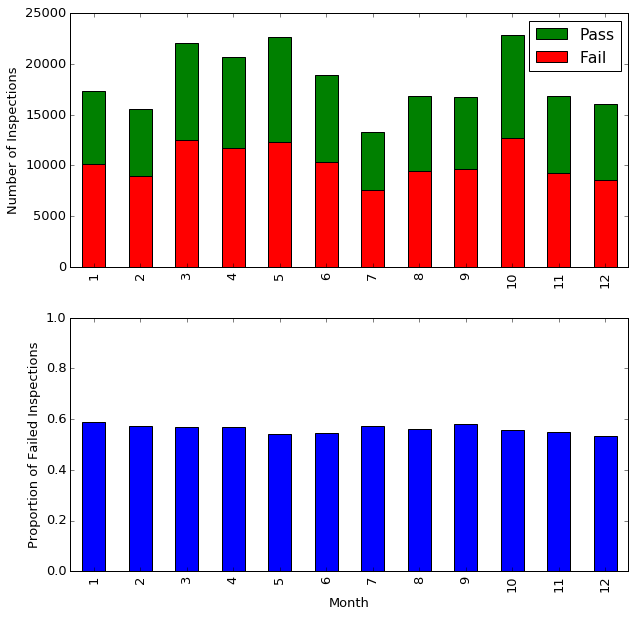

In [9]:
import matplotlib.pyplot as plt
#import seaborn as sb
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 13
plt.subplot(2,1,1)
ax = inspections[
    inspections.violation_date <= '2015-12-31 00:00:00'
].result_date.dt.month.value_counts().sort_index().plot(kind = 'bar', color='green')
inspections[
    (inspections.status == 'Fail') & (inspections.violation_date <= '2015-12-31 00:00:00')
].result_date.dt.month.value_counts().sort_index().plot(kind = 'bar', ax = ax, color = 'red')
plt.legend(['Pass','Fail'])
plt.ylabel('Number of Inspections')
plt.subplot(2,1,2)
(
    (inspections[
            (inspections.status == 'Fail') & (inspections.violation_date <= '2015-12-31 00:00:00')
        ].result_date.dt.month.value_counts().sort_index()) 
    / 
    (inspections[inspections.violation_date <= '2015-12-31 00:00:00'].result_date.dt.month.value_counts().sort_index())
).plot(kind = 'bar', ylim=[0,1])
plt.xlabel('Month')
plt.ylabel('Proportion of Failed Inspections')

### Focusing on rodent issues
About 1500 establishments (35% of the total) have experienced inspection failures related to rodents.

In [10]:
len(inspections[
        (inspections.status == 'Fail') 
        & (inspections.description.str.contains('odent'))
    ].name.unique())

1498

Inspections with rodent-related issues are an interesting subset of all inspections, because we can directly investigate whether citizens' reports of rodent sightings (through 311 service calls) are good predictors of subsequent rodent-related issues during health inspections of nearby food service establishments. 

#### Patterns in time

Intriguingly, based on service call data, rodents are reported via 311 most commonly around June to August, and are detected in health inspections most commonly shortly thereafter, in July to September. 

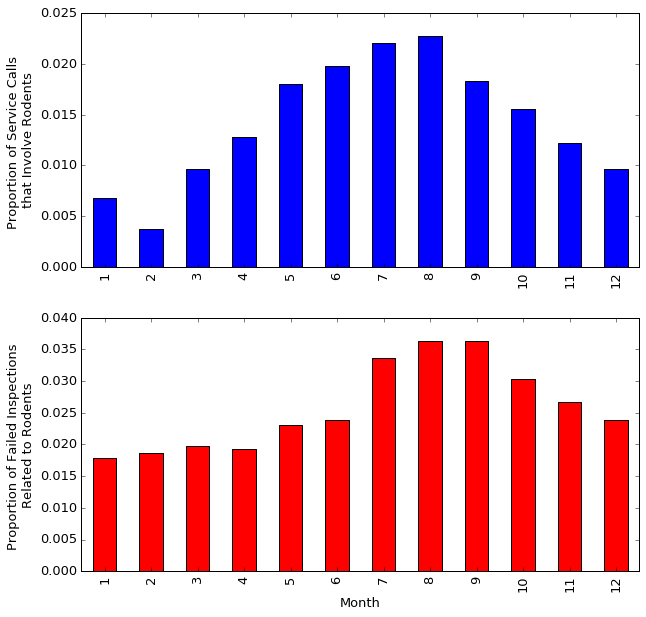

In [11]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 13
plt.subplot(2,1,1)
(
    services[services.title.fillna('').str.contains('odent')].open.dt.month.value_counts().sort_index()
    /
    services.open.dt.month.value_counts().sort_index()
).plot(kind = 'bar')
plt.ylabel('Proportion of Service Calls \nthat Involve Rodents')
plt.subplot(2,1,2)
(
    (inspections[
            (inspections.status=='Fail') &
            (inspections.description.str.contains('odent'))
        ].result_date.dt.month.value_counts().sort_index()) 
    / 
    (inspections[inspections.status=='Fail'].result_date.dt.month.value_counts().sort_index())
).plot(kind = 'bar', color='red')
plt.xlabel('Month')
plt.ylabel('Proportion of Failed Inspections \nRelated to Rodents')

The pattern of an increase in public rodent sightings followed by an increase in rodent-related inspection issues seems to repeat year after year.

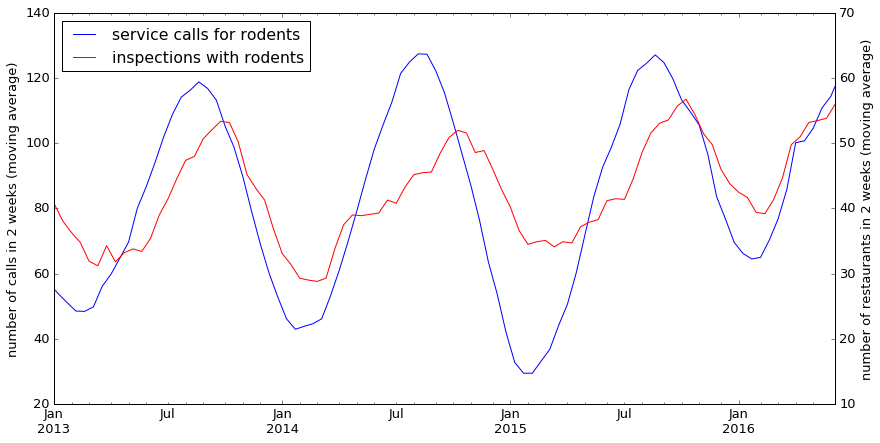

In [12]:
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 13
ax = services[services.title.fillna('').str.contains('odent')].set_index(
    'open'
)[['status']].rename(columns = {'status':'service calls for rodents'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    xlim=['2013-01-01 00:00:00','2016-06-01 00:00:00']
)
plt.ylabel('number of calls in 2 weeks (moving average)')
inspections[inspections.description.fillna('').str.contains('odent')].set_index(
    'result_date'
)[['status']].rename(columns = {'status':'inspections with rodents'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    xlim=['2013-01-01 00:00:00','2016-06-01 00:00:00'], 
    ax = ax, 
    sharex = True, 
    secondary_y = True, 
    mark_right = False,
    c = 'red'
)
plt.ylabel('number of restaurants in 2 weeks (moving average)')
ax.set_xlabel('')

On the other hand, for the total number of service calls, and total failed inspections, there is no cyclical pattern over time and no clear correlation between the two. For both, there is an overall upward trend over time. (However, there was an anomalous rise in failed inspections around April 2014, and in service calls around February 2015.)

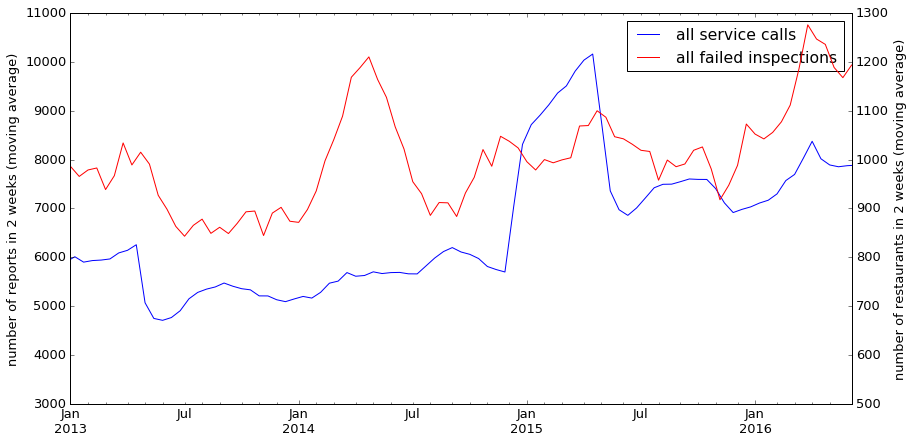

In [13]:
ax = services.set_index(
    'open'
)[['status']].rename(columns = {'status':'all service calls'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    xlim=['2013-01-01 00:00:00','2016-06-01 00:00:00']
)
plt.ylabel('number of reports in 2 weeks (moving average)')
inspections[inspections.status == 'Fail'].set_index(
    'result_date'
)[['status']].rename(columns = {'status':'all failed inspections'}).resample('2w').count().fillna(0).rolling(
    window=10, min_periods=1, center=True
).mean().plot(
    kind='line', 
    xlim=['2013-01-01 00:00:00','2016-06-01 00:00:00'], 
    ax = ax, 
    sharex = True, 
    secondary_y = True, 
    mark_right = False,
    c = 'red'
)
plt.ylabel('number of restaurants in 2 weeks (moving average)')
ax.set_xlabel('')

The visible correlation between the timing of rodent service calls and of rodent-related inspection issues is made all the more suggestive by the lack of any such apparent correlation between service calls as a whole and failed inspections as a whole.

#### Patterns in location

With somewhat more effort, we can use visuals to explore whether there might be a correlation between the locations of rodent sightings and of rodent-related inspection issues. For the graphs below, three different 7-day periods are selected (more or less at random) and service calls involving rodent activity during those perios are mapped. This reported rodent activity is indicated in green, with darker green corresponding to more activity. Then, rodent-related health inspections during a period starting two weeks later are shown in red. The length of delay between sightings and inspections is chosen somewhat arbitrarily, but in each case, the distributions of sightings and rodent-related inspection results do appear to have some rough similarities. With further work, we might choose the length of delay more carefully and adopt some objective measure for this apparent correlation. 

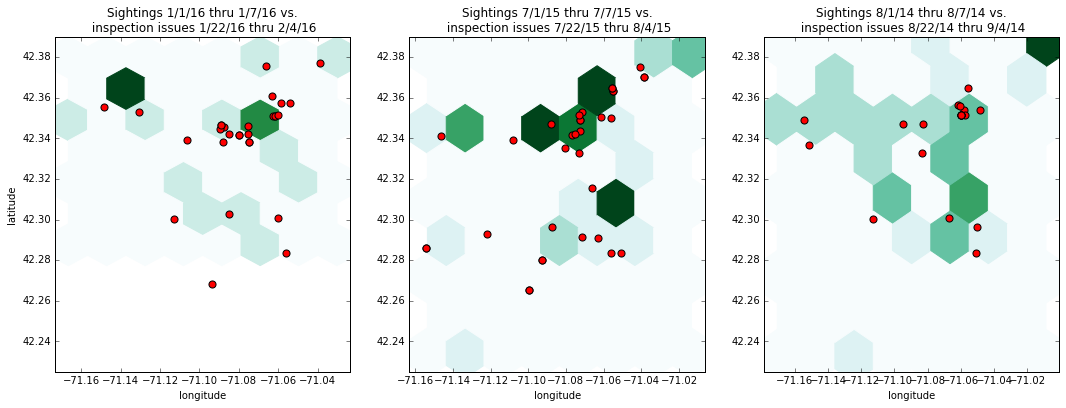

In [14]:
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['font.size'] = 10
ax = plt.subplot(1,3,1)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2016-01-01 00:00:00' <= services.open) &
    (services.open <= '2016-01-07 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=[7,3],colorbar=False,ax=ax,ylim=[42.225,42.39])
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2016-01-22 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2016-02-04 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=50)
ax.set_title('Sightings 1/1/16 thru 1/7/16 vs.\n inspection issues 1/22/16 thru 2/4/16')

ax = plt.subplot(1,3,2)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2015-07-01 00:00:00' <= services.open) &
    (services.open <= '2015-07-07 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=7,colorbar=False, ax=ax,ylim=[42.225,42.39])
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2015-07-22 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2015-08-04 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=50)
plt.ylabel('')
ax.set_title('Sightings 7/1/15 thru 7/7/15 vs.\n inspection issues 7/22/15 thru 8/4/15')


ax = plt.subplot(1,3,3)
services[
    (services.title.fillna('').str.contains('odent')) &
    ('2014-08-01 00:00:00' <= services.open) &
    (services.open <= '2014-08-07 00:00:00')
].plot.hexbin(x='longitude',y='latitude',gridsize=7,colorbar=False,ax=ax,ylim=[42.225,42.39])
inspections[
    (inspections.description.fillna('').str.contains('odent')) &
    ('2014-08-22 00:00:00' <= inspections.result_date) &
    (inspections.result_date <= '2014-09-04 00:00:00')
].plot(x='longitude',y='latitude',kind='scatter',ax=ax,color='red', s=50)
plt.ylabel('')
ax.set_title('Sightings 8/1/14 thru 8/7/14 vs.\n inspection issues 8/22/14 thru 9/4/14')

We have focused here on just one aspect of health inspections, as a microcosm of the predictive relationship between service call data and inspection outcomes. The mostly visual exploration above gives good reason to believe that we can predict rodent-related inspection issues from recent service calls for rodent activity. By analogy, combining other aspects of the available service call data (along with other sources of data not used here) will allow us to construct a model for predicting the timing and location of a much broader variety of health inspection failures.